### Installing the Required Libaries

In [1]:
!pip install pandas

  Using cached pandas-1.2.3-cp37-cp37m-win_amd64.whl (9.1 MB)
  Using cached numpy-1.20.2-cp37-cp37m-win_amd64.whl (13.6 MB)
  Using cached pytz-2021.1-py2.py3-none-any.whl (510 kB)


In [2]:
!pip install matplotlib

  Using cached matplotlib-3.4.1-cp37-cp37m-win_amd64.whl (7.1 MB)
  Using cached Pillow-8.2.0-cp37-cp37m-win_amd64.whl (2.2 MB)
  Using cached kiwisolver-1.3.1-cp37-cp37m-win_amd64.whl (51 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


In [3]:
!pip install seaborn

  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)


In [4]:
!pip install scikit-learn

  Using cached scikit_learn-0.24.1-cp37-cp37m-win_amd64.whl (6.8 MB)
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)


In [5]:
!pip install hyperopt

  Using cached hyperopt-0.2.5-py2.py3-none-any.whl (965 kB)
  Using cached cloudpickle-1.6.0-py3-none-any.whl (23 kB)
  Using cached networkx-2.5-py3-none-any.whl (1.6 MB)
  Using cached tqdm-4.59.0-py2.py3-none-any.whl (74 kB)
  Using cached future-0.18.2-py3-none-any.whl


### Importing the Required Libaries

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_rows', 1600)
pd.set_option('display.max_columns', 1600)
import urllib.request, json 
from math import radians
import sklearn.neighbors
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from hyperopt.pyll import scope as ho_scope
from sklearn.model_selection import StratifiedKFold
import statistics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import datetime
%matplotlib inline

### Reading the Data

In [7]:
with urllib.request.urlopen("https://feeds.citibikenyc.com/stations/stations.json") as url:
    stations = json.loads(url.read().decode())
    stations = pd.DataFrame(stations['stationBeanList'])

print(stations.shape)
stations.head()

(509, 18)


,id,stationName,availableDocks,totalDocks,latitude,longitude,statusValue,statusKey,availableBikes,stAddress1,stAddress2,city,postalCode,location,altitude,testStation,lastCommunicationTime,landMark
0,72,W 52 St & 11 Ave,32,39,40.77,-73.99,In Service,1,7,W 52 St & 11 Ave,,,,,,False,2016-01-22 04:30:15 PM,
1,79,Franklin St & W Broadway,0,33,40.72,-74.01,In Service,1,33,Franklin St & W Broadway,,,,,,False,2016-01-22 04:32:41 PM,
2,82,St James Pl & Pearl St,27,27,40.71,-74.00,In Service,1,0,St James Pl & Pearl St,,,,,,False,2016-01-22 04:29:41 PM,
3,83,Atlantic Ave & Fort Greene Pl,21,62,40.68,-73.98,In Service,1,40,Atlantic Ave & Fort Greene Pl,,,,,,False,2016-01-22 04:32:33 PM,
4,116,W 17 St & 8 Ave,19,39,40.74,-74.00,In Service,1,19,W 17 St & 8 Ave,,,,,,False,2016-01-22 04:32:32 PM,


In [8]:
collision_data=pd.DataFrame()
for i in range(1,6):
    file='NY_Collision_Data_'+str(i)+'.csv'
    print('Reading File : ',file)
    df = pd.read_csv('./'+file)
    collision_data = collision_data.append(df)

print('shape = ', collision_data.shape)
collision_data.head()

Reading File :  NY_Collision_Data_1.csv
Reading File :  NY_Collision_Data_2.csv
Reading File :  NY_Collision_Data_3.csv
Reading File :  NY_Collision_Data_4.csv
Reading File :  NY_Collision_Data_5.csv
shape =  (1762970, 29)


,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,collision_id,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5
0,12/04/2019,19:25,QUEENS,"11,429.0",40.71,-73.75,"(40.70681, -73.751015)",NaN,NaN,109-72 FRANCIS LEWIS BOULEVARD,0.00,0.00,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4252615,Sedan,Sedan,NaN,NaN,NaN
1,12/24/2019,18:45,NaN,NaN,NaN,NaN,NaN,VANWYCK EXPRESSWAY,LINDEN BOULEVARD,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4266390,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
2,12/13/2019,16:45,BROOKLYN,"11,230.0",40.64,-73.97,"(40.63524, -73.967636)",18 AVENUE,CONEY ISLAND AVENUE,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4258065,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
3,12/28/2019,4:00,NaN,NaN,40.77,-73.89,"(40.766685, -73.892136)",77 STREET,ASTORIA BOULEVARD,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inexperience,Unspecified,NaN,NaN,NaN,4265714,Sedan,Sedan,NaN,NaN,NaN
4,12/04/2019,11:54,MANHATTAN,"10,022.0",NaN,NaN,NaN,WEST 53 STREET,5 AVENUE,NaN,0.00,0.00,0,0,0,0,0,0,Other Vehicular,Other Vehicular,NaN,NaN,NaN,4252095,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN


In [9]:
# Removing rows with null lat longs
collision_data_2 = collision_data.loc[(collision_data.latitude.notnull() & collision_data.longitude.notnull())]
print('shape = ',collision_data_2.shape)

shape =  (1554134, 29)


In [10]:
def lookup(s):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

In [11]:
# Converting crash_date to datetime
collision_data_2.crash_date = lookup(collision_data_2.crash_date)

#### Filling in nulls for Borough

In [12]:
data_2018 = collision_data_2.loc[(collision_data_2.crash_date<pd.datetime(2019,1,1)) &
                                (collision_data_2.borough.notnull())][['collision_id','borough','latitude','longitude']]
sample_df=data_2018.sample(frac=0.30, random_state=123)

X=sample_df[['collision_id','latitude','longitude']]#,'accident_reason'
y=sample_df[['borough']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

borough_nulls_model = RandomForestClassifier()
ovr_nulls_model = OneVsRestClassifier(borough_nulls_model)
ovr_nulls_model.fit(X_train, y_train)
yhat_ovr_nulls = ovr_nulls_model.predict(X_test)

print('Overall Accuracy : ',accuracy_score(y_test,yhat_ovr_nulls))
print(classification_report(y_test,yhat_ovr_nulls))

Training Set: 219052 rows
Test Set: 73018 rows
Overall Accuracy :  0.9988085129694048
               precision    recall  f1-score   support

        BRONX       1.00      1.00      1.00      9835
     BROOKLYN       1.00      1.00      1.00     22776
    MANHATTAN       1.00      1.00      1.00     17847
       QUEENS       1.00      1.00      1.00     19342
STATEN ISLAND       1.00      1.00      1.00      3218

     accuracy                           1.00     73018
    macro avg       1.00      1.00      1.00     73018
 weighted avg       1.00      1.00      1.00     73018



In [13]:
borough_nulls=collision_data_2.loc[collision_data_2.borough.isnull()][['collision_id','latitude','longitude']]

borough_nulls.reset_index(inplace=True,drop=True)

borough_preds=ovr_nulls_model.predict(borough_nulls)

borough_nulls['borough_pred']=borough_preds

collision_data_2 = collision_data_2.merge(borough_nulls[['collision_id','borough_pred']],on=['collision_id'],how='left')


collision_data_2.loc[collision_data_2.borough.isnull(),'borough_new']=collision_data_2['borough_pred']
collision_data_2.loc[collision_data_2.borough.notnull(),'borough_new']=collision_data_2['borough']

collision_data_2.drop(['borough','borough_pred'],inplace=True,axis=1)
collision_data_2.rename(columns={'borough_new':'borough'},inplace=True)
print('Null Count in Borough column : ',collision_data_2.borough.isnull().sum())
collision_data_2.head()

Null Count in Borough column :  0


,crash_date,crash_time,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,collision_id,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,borough
0,2019-12-04,19:25,"11,429.0",40.71,-73.75,"(40.70681, -73.751015)",NaN,NaN,109-72 FRANCIS LEWIS BOULEVARD,0.00,0.00,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4252615,Sedan,Sedan,NaN,NaN,NaN,QUEENS
1,2019-12-13,16:45,"11,230.0",40.64,-73.97,"(40.63524, -73.967636)",18 AVENUE,CONEY ISLAND AVENUE,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4258065,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,BROOKLYN
2,2019-12-28,4:00,NaN,40.77,-73.89,"(40.766685, -73.892136)",77 STREET,ASTORIA BOULEVARD,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inexperience,Unspecified,NaN,NaN,NaN,4265714,Sedan,Sedan,NaN,NaN,NaN,QUEENS
3,2019-12-27,16:50,"11,375.0",40.72,-73.85,"(40.721363, -73.84808)",AUSTIN STREET,69 ROAD,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inexperience,Unspecified,NaN,NaN,NaN,4265377,Sedan,Motorcycle,NaN,NaN,NaN,QUEENS
4,2019-12-10,23:23,"11,236.0",40.63,-73.90,"(40.63489, -73.90114)",NaN,NaN,8902 AVENUE L,0.00,0.00,0,0,0,0,0,0,View Obstructed/Limited,Unspecified,NaN,NaN,NaN,4256278,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,BROOKLYN


### Finding the Most Dangerous Borough For Cyclists

In [14]:
danger_cyclist=collision_data.groupby(['borough'],as_index=False).agg({'number_of_cyclist_injured':'sum',
                                                             'number_of_cyclist_killed':'sum'
                                                          }).sort_values(ascending=False,by='borough')
danger_cyclist.columns = [col.replace('_',' ').title() for col in danger_cyclist.columns]

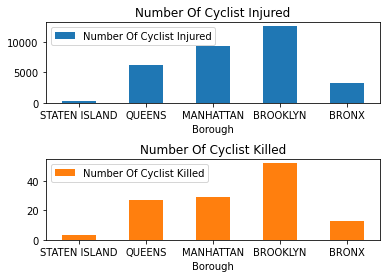

In [15]:
axes = danger_cyclist.plot.bar(x='Borough',rot=0, subplots=True,sharex=False)
axes[0].legend(loc=2)
axes[1].legend(loc=2)
plt.subplots_adjust(hspace=0.7)
plt.show()

**Conclusion :**

- The most dangerous borough for cyclists is Brooklyn

### Calculating distance between each crash and nearest bike station

In [16]:
# Seperating lat longs of stations and collisions
col_temp = collision_data_2[['collision_id','latitude','longitude']]
st_temp = stations[['id','latitude','longitude']]

# Converting lat longs to radians
col_temp[['lat_radians_C','long_radians_C']] = (
    np.radians(col_temp.loc[:,['latitude','longitude']]))
st_temp[['lat_radians_S','long_radians_S']] = (
    np.radians(st_temp.loc[:,['latitude','longitude']]))

# Computing distance(in miles) of each station with each collison
# (in form of a matrix with dimensions = no. of collisions * no of bike stations)

dist = sklearn.neighbors.DistanceMetric.get_metric('haversine')
dist_matrix = (dist.pairwise
    (col_temp[['lat_radians_C','long_radians_C']],
     st_temp[['lat_radians_S','long_radians_S']])*3959
)
# Note that 3959 is the radius of the earth in miles

df_dist_matrix = (
    pd.DataFrame(dist_matrix,index=col_temp['collision_id'], 
                 columns=st_temp['id'])
)

df_dist_matrix.head()

id,72,79,82,83,116,119,120,127,128,137,143,144,146,147,150,151,152,153,157,160,161,164,167,168,173,174,195,212,216,217,223,224,225,228,229,232,233,236,237,238,239,241,242,243,244,245,247,248,249,250,251,252,253,254,257,258,259,260,261,262,263,264,265,266,267,268,270,274,275,276,278,279,280,281,282,284,285,289,291,293,295,296,297,298,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,319,320,321,322,323,324,325,326,327,328,329,330,331,332,334,335,336,337,339,340,341,342,343,344,345,346,347,348,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,372,373,375,376,377,379,380,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,405,406,407,408,409,410,411,412,414,415,416,417,418,419,420,421,422,423,426,427,428,430,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,453,454,455,456,457,458,459,460,461,462,463,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,536,537,539,540,545,546,2000,2001,2002,2003,2004,2005,2006,2008,2009,2010,2012,2017,2021,2022,2023,3002,3041,3042,3043,3044,3046,3047,3048,3049,3050,3052,3053,3054,3055,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071,3072,3073,3074,3075,3076,3077,3078,3079,3080,3081,3082,3083,3084,3085,3086,3087,3088,3089,3090,3091,3092,3093,3094,3095,3096,3097,3098,3099,3100,3101,3102,3103,3104,3105,3106,3107,3108,3109,3110,3111,3112,3113,3114,3115,3116,3117,3118,3119,3120,3121,3122,3123,3124,3125,3126,3127,3128,3129,3131,3132,3134,3135,3136,3137,3138,3139,3140,3141,3142,3143,3144,3145,3146,3147,3148,3150,3151,3152,3153,3154,3155,3156,3157,3158,3159,3160,3161,3162,3163,3164,3165,3166,3167,3168,3169,3170,3171,3172,3173,3175,3176,3177,3178,3179,3180,3183,3184,3185,3186,3187,3188,3189,3190,3191,3192,3193,3194,3195,3196,3197,3198,3199,3200,3201,3202,3203,3205,3206,3207,3209,3210,3211,3212,3213,3214,3215,3216,3217,3220,3221,3222,3223,3224,3225,3226,3229,3230,3231,3232,3233,3235,3236,3237,3238,3241,3242,3243,3244
collision_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4252615,13.39,13.42,13.05,11.91,13.34,11.92,11.00,13.50,13.27,12.22,12.74,12.05,13.53,13.64,12.08,12.94,13.53,12.47,12.89,12.24,13.03,11.92,12.14,12.95,12.78,12.05,13.59,13.63,12.81,12.72,13.21,13.33,13.68,12.03,12.79,12.55,12.57,12.46,12.45,13.64,12.11,11.79,11.68,12.03,11.28,11.88,13.44,13.48,13.54,12.87,12.82,13.08,12.91,13.08,13.20,11.48,13.69,13.66,12.21,11.71,12.87,13.43,12.64,11.83,12.76,13.05,11.60,11.90,11.33,13.61,12.26,13.13,12.91,12.32,11.38,13.36,12.70,10.99,12.26,12.66,12.68,12.90,12.50,12.06,12.61,12.23,11.92,13.07,13.76,11.92,13.32,12.52,12.97,13.73,12.53,12.43,12.51,11.37,12.58,13.40,13.39,12.15,13.54,13.35,12.51,12.60,12.37,12.11,12.41,12.32,13.92,13.60,13.61,13.35,12.62,11.97,13.13,12.82,13.09,13.48,11.76,12.41,11.82,12.02,11.48,10.73,13.05,13.52,13.58,13.18,12.38,13.36,12.47,11.79,11.10,13.04,12.15,12.72,13.53,12.19,13.51,12.63,12.77,13.94,11.03,11.16,11.45,12.04,13.25,13.17,10.88,10.66,12.95,13.42,13.38,12.93,13.33,12.77,13.20,11.33,11.80,13.18,13.29,13.52,11.22,12.26,12.72,12.40,12.04,11.94,12.28,10.88,11.54,13.08,11.27,12.12,12.55,12.70,12.62,13.65,12.86,12.60,12.73,10.82,12.30,11.87,12.75,12.40,13.53,11.69,13.58,12.13,11.68,11.53,11.56,13.17,13.01,13.75,13.78,12.46,12.34,12.26,12.12,13.47,12.96,10

In [17]:
# Retrieving nearest station distance & id and combining the nearest bike station info with collisons data

nearest_station_id = pd.DataFrame(df_dist_matrix.idxmin(axis=1))
nearest_station_dist = pd.DataFrame(df_dist_matrix.min(axis=1))

nearest_station_id.columns=['id']
nearest_station_dist.columns=['distance']

# consolidating nearest station distance and id info and merging with collisons data
nearest_station_df = nearest_station_id.merge(nearest_station_dist,on='collision_id')
collision_data_2=collision_data_2.merge(nearest_station_df,on='collision_id')

collision_station_comb = collision_data_2.merge(stations[['id','stationName','availableDocks',
                                 'totalDocks','latitude','longitude',
                                 'statusValue','statusKey','availableBikes']],on='id',how='left')

collision_station_comb.head()

,crash_date,crash_time,zip_code,latitude_x,longitude_x,location,on_street_name,cross_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,collision_id,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,borough,id,distance,stationName,availableDocks,totalDocks,latitude_y,longitude_y,statusValue,statusKey,availableBikes
0,2019-12-04,19:25,"11,429.0",40.71,-73.75,"(40.70681, -73.751015)",NaN,NaN,109-72 FRANCIS LEWIS BOULEVARD,0.00,0.00,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4252615,Sedan,Sedan,NaN,NaN,NaN,QUEENS,3042,9.56,Fulton St & Utica Ave,2,19,40.68,-73.93,In Service,1,16
1,2019-12-13,16:45,"11,230.0",40.64,-73.97,"(40.63524, -73.967636)",18 AVENUE,CONEY ISLAND AVENUE,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4258065,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,BROOKLYN,396,3.18,Lefferts Pl & Franklin Ave,22,25,40.68,-73.96,In Service,1,3
2,2019-12-28,4:00,NaN,40.77,-73.89,"(40.766685, -73.892136)",77 STREET,ASTORIA BOULEVARD,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inexperience,Unspecified,NaN,NaN,NaN,4265714,Sedan,Sedan,NaN,NaN,NaN,QUEENS,3123,2.73,31 St & Thomson Ave,7,27,40.74,-73.94,In Service,1,20
3,2019-12-27,16:50,"11,375.0",40.72,-73.85,"(40.721363, -73.84808)",AUSTIN STREET,69 ROAD,NaN,0.00,0.00,0,0,0,0,0,0,Driver Inexperience,Unspecified,NaN,NaN,NaN,4265377,Sedan,Motorcycle,NaN,NaN,NaN,QUEENS,3221,4.82,47 Ave & 31 St,12,27,40.74,-73.94,In Service,1,15
4,2019-12-10,23:23,"11,236.0",40.63,-73.90,"(40.63489, -73.90114)",NaN,NaN,8902 AVENUE L,0.00,0.00,0,0,0,0,0,0,View Obstructed/Limited,Unspecified,NaN,NaN,NaN,4256278,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,BROOKLYN,3042,3.43,Fulton St & Utica Ave,2,19,40.68,-73.93,In Service,1,16


#### Cleansing vehicle_type_code columns

In [18]:
collision_station_comb['vehicle_type_code_1'] = collision_station_comb['vehicle_type_code_1'].str.lower()
collision_station_comb['vehicle_type_code_2'] = collision_station_comb['vehicle_type_code_2'].str.lower()
collision_station_comb['vehicle_type_code_3'] = collision_station_comb['vehicle_type_code_3'].str.lower()

collision_station_comb['vehicle_type_code_1'].fillna('unknown',axis=0,inplace=True)
collision_station_comb['vehicle_type_code_2'].fillna('unknown',axis=0,inplace=True)
collision_station_comb['vehicle_type_code_3'].fillna('unknown',axis=0,inplace=True)

collision_station_comb['vehicle_type_code_1'].replace('minibike','minicycle',inplace=True)
collision_station_comb['vehicle_type_code_2'].replace('minibike','minicycle',inplace=True)
collision_station_comb['vehicle_type_code_3'].replace('minibike','minicycle',inplace=True)

collision_station_comb['vehicle_type_code_1'].replace('motorbike','motorcycle',inplace=True)
collision_station_comb['vehicle_type_code_2'].replace('motorbike','motorcycle',inplace=True)
collision_station_comb['vehicle_type_code_3'].replace('motorbike','motorcycle',inplace=True)

#### Recommending locations to increase safety for cyclists

In [19]:
df = pd.DataFrame(collision_station_comb.loc[(collision_station_comb.vehicle_type_code_1.str.contains('bike|bicycle')) |
                          (collision_station_comb.vehicle_type_code_2.str.contains('bike|bicycle')) |
                           (collision_station_comb.vehicle_type_code_3.str.contains('bike|bicycle')) ].groupby([
    'id','borough'],as_index=False).agg({'collision_id':'count',
                                         'number_of_cyclist_injured':'sum',
                                         'number_of_cyclist_killed':'sum',
                                         'number_of_persons_injured':'sum',
                                         'number_of_persons_killed':'sum'}).sort_values(ascending=False,by='collision_id'))

df.columns = [col.replace('_',' ').title() for col in df.columns]
df.rename(columns={'Collision Id':'Collision Count'},inplace=True)
df.head()

,Id,Borough,Collision Count,Number Of Cyclist Injured,Number Of Cyclist Killed,Number Of Persons Injured,Number Of Persons Killed
456,3157,BRONX,3837,3039,17,"3,206.00",17.00
423,3123,QUEENS,3373,2822,5,"2,948.00",5.00
242,467,BROOKLYN,3372,2776,10,"2,921.00",10.00
334,3042,BROOKLYN,2947,2443,11,"2,567.00",11.00
471,3168,MANHATTAN,2507,1860,4,"1,970.00",4.00


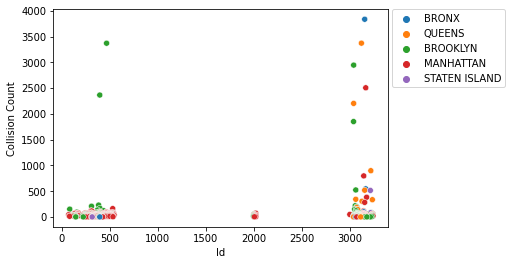

<Figure size 1296x1296 with 0 Axes>

In [20]:

sns.scatterplot(data=df, x='Id', y='Collision Count', hue='Borough')
#plt.legend(loc='upper left')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.figure(figsize=(18,18))
plt.show()

**Observation :**
- The Increase safety of the cyclists, the location of bike stations with Collision Count > 1500 need to be changed
- The location should be moved near bike stations with Collision Count < 500 as per available data
- The data however doesn't show the complete picture. To accurately recommend the location, data such as population in area,no. of building,traffic congestion,weather and infrastructure would be required

In [21]:
df.sort_values(by='Collision Count',ascending=False).head(8)

,Id,Borough,Collision Count,Number Of Cyclist Injured,Number Of Cyclist Killed,Number Of Persons Injured,Number Of Persons Killed
456,3157,BRONX,3837,3039,17,"3,206.00",17.00
423,3123,QUEENS,3373,2822,5,"2,948.00",5.00
242,467,BROOKLYN,3372,2776,10,"2,921.00",10.00
334,3042,BROOKLYN,2947,2443,11,"2,567.00",11.00
471,3168,MANHATTAN,2507,1860,4,"1,970.00",4.00
177,396,BROOKLYN,2366,1948,11,"2,031.00",11.00
336,3042,QUEENS,2204,1864,10,"1,925.00",10.00
331,3041,BROOKLYN,1851,1545,7,"1,629.00",7.00


In [22]:
df.sort_values(by='Collision Count',ascending=True).head()

,Id,Borough,Collision Count,Number Of Cyclist Injured,Number Of Cyclist Killed,Number Of Persons Injured,Number Of Persons Killed
176,396,BRONX,1,1,0,1.00,0.00
178,396,QUEENS,1,1,0,1.00,0.00
332,3041,QUEENS,1,1,0,1.00,0.00
357,3064,BRONX,1,1,0,1.00,0.00
370,3074,MANHATTAN,1,0,0,0.00,0.00


#### Recommending locations to increase safety overall

In [23]:
df_ovr = collision_station_comb.groupby([
    'id','borough'],as_index=False).agg({'collision_id':'count',
                                         'number_of_cyclist_injured':'sum',
                                         'number_of_cyclist_killed':'sum',
                                         'number_of_persons_injured':'sum',
                                         'number_of_persons_killed':'sum'}).sort_values(ascending=False,by='collision_id')

df_ovr.columns = [col.replace('_',' ').title() for col in df_ovr.columns]
df_ovr.rename(columns={'Collision Id':'Collision Count'},inplace=True)
df_ovr.head()

,Id,Borough,Collision Count,Number Of Cyclist Injured,Number Of Cyclist Killed,Number Of Persons Injured,Number Of Persons Killed
588,3157,BRONX,187865,3246,18,"58,673.00",268.00
429,3042,QUEENS,170811,1916,11,"55,539.00",243.00
547,3123,QUEENS,135337,2889,5,"34,629.00",202.00
427,3042,BROOKLYN,128658,2560,12,"47,420.00",201.00
314,467,BROOKLYN,86982,2859,12,"22,849.00",106.00


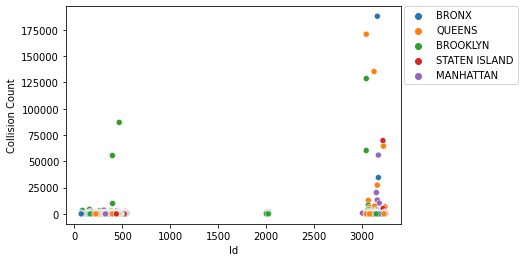

<Figure size 1080x1080 with 0 Axes>

In [24]:
sns.scatterplot(data=df_ovr, x='Id', y='Collision Count', hue='Borough')
#plt.legend(loc='upper left')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.figure(figsize=(15,15))
plt.show()

**Observation :**
- The Increase safety overall, the location of bike stations with Collision Count > 50000 need to be changed
- The location should be moved in area of bike stations with Collision Count < 25000 as per available data
- The data however doesn't show the complete picture. To accurately recommend the location, data such as population in area,no. of building,traffic congestion,weather and infrastructure would be required

In [25]:
df_ovr.sort_values(by='Collision Count',ascending=False).head(10)

,Id,Borough,Collision Count,Number Of Cyclist Injured,Number Of Cyclist Killed,Number Of Persons Injured,Number Of Persons Killed
588,3157,BRONX,187865,3246,18,"58,673.00",268.00
429,3042,QUEENS,170811,1916,11,"55,539.00",243.00
547,3123,QUEENS,135337,2889,5,"34,629.00",202.00
427,3042,BROOKLYN,128658,2560,12,"47,420.00",201.00
314,467,BROOKLYN,86982,2859,12,"22,849.00",106.00
629,3216,STATEN ISLAND,69699,427,4,"18,663.00",103.00
635,3221,QUEENS,64387,741,2,"17,145.00",75.00
422,3041,BROOKLYN,60254,1588,7,"19,888.00",78.00
605,3168,MANHATTAN,55936,1966,4,"14,168.00",52.00
223,396,BROOKLYN,55496,2001,11,"16,786.00",67.00


In [26]:
df_ovr.sort_values(by='Collision Count',ascending=True).head()

,Id,Borough,Collision Count,Number Of Cyclist Injured,Number Of Cyclist Killed,Number Of Persons Injured,Number Of Persons Killed
0,72,BRONX,1,0,0,0.00,0.00
11,137,QUEENS,1,0,0,0.00,0.00
13,143,STATEN ISLAND,1,0,0,0.00,0.00
15,144,MANHATTAN,1,0,0,0.00,0.00
16,146,BROOKLYN,1,1,0,1.00,0.00


### Additional Insights

In [27]:
def lookup(s):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

In [28]:
collision_station_comb.crash_date = lookup(collision_station_comb.crash_date)

In [29]:
# Creating Extra features for insights and predictive modelling

collision_station_comb['crash_month']=collision_station_comb.crash_date.dt.month
collision_station_comb['crash_year']=collision_station_comb.crash_date.dt.year
collision_station_comb['crash_day']=collision_station_comb.crash_date.dt.day_name()
collision_station_comb['crash_week']=collision_station_comb.crash_date.dt.week
collision_station_comb['crash_day_of_week']=collision_station_comb.crash_date.dt.dayofweek

collision_station_comb.loc[collision_station_comb.crash_day_of_week.isin([5,6]),'is_weekend']=1
collision_station_comb.loc[~collision_station_comb.crash_day_of_week.isin([5,6]),'is_weekend']=0

In [30]:
collision_station_comb.isnull().sum()

crash_date                             0
crash_time                             0
zip_code                          364510
latitude_x                             0
longitude_x                            0
location                               0
on_street_name                    302103
cross_street_name                 541259
off_street_name                  1314074
number_of_persons_injured             16
number_of_persons_killed              28
number_of_pedestrians_injured          0
number_of_pedestrians_killed           0
number_of_cyclist_injured              0
number_of_cyclist_killed               0
number_of_motorist_injured             0
number_of_motorist_killed              0
contributing_factor_vehicle_1       4455
contributing_factor_vehicle_2     224443
contributing_factor_vehicle_3    1450504
contributing_factor_vehicle_4    1531644
contributing_factor_vehicle_5    1548173
collision_id                           0
vehicle_type_code_1                    0
vehicle_type_cod

In [31]:
collision_station_comb.contributing_factor_vehicle_1.fillna('Unspecified',inplace=True,axis=0)
collision_station_comb.number_of_persons_killed.fillna(0,inplace=True,axis=0)
collision_station_comb.number_of_persons_injured.fillna(0,inplace=True,axis=0)

In [32]:
#reading the conributing_factor_vehicle lookup for grouping accident reasons
contributing_factor_lookup=pd.read_csv('./contributing_factor_lookup.csv')
collision_station_comb = collision_station_comb.merge(
    contributing_factor_lookup,on='contributing_factor_vehicle_1',how='left')

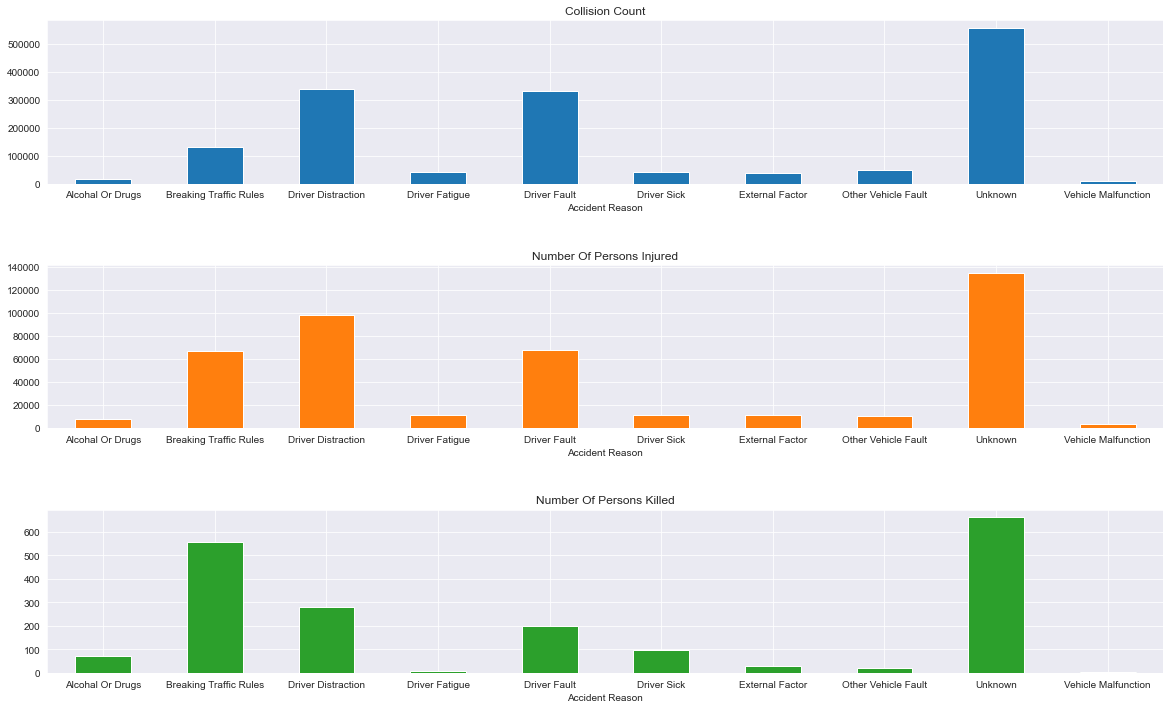

In [33]:
accident_reason = collision_station_comb.groupby(['accident_reason'],as_index=False).agg({'collision_id':'count',
                                                 'number_of_persons_injured':'sum',
                                                 'number_of_persons_killed':'sum'})
sns.set_style('darkgrid')
accident_reason.columns = [col.replace('_',' ').title() for col in accident_reason.columns]
accident_reason.rename(columns={'Collision Id':'Collision Count'},inplace=True)
accident_reason['Accident Reason'] = accident_reason['Accident Reason'].apply(lambda x:x.replace('_',' ').title())
accident_reason.plot.bar(x='Accident Reason',subplots=True,rot=0,figsize=(20,12),legend=False,sharex=False)
plt.subplots_adjust(hspace=0.5)
plt.show()

**Observation:**
- Mostly Collisions occur due to Driver's Fault or Driver's Distraction
- However, Collisions caused because Breaking of Traffic Rules result in more deaths

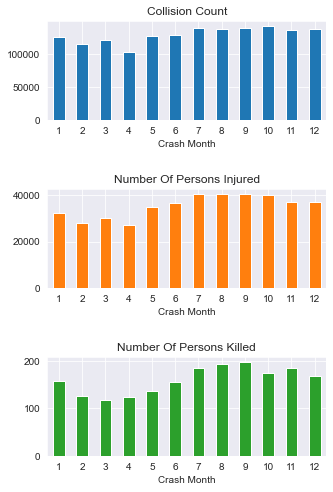

In [34]:
crash_month = collision_station_comb.groupby(['crash_month'],as_index=False).agg({'collision_id':'count',
                                                 'number_of_persons_injured':'sum',
                                                 'number_of_persons_killed':'sum'
                                                                   })
crash_month.columns = [col.replace('_',' ').title() for col in crash_month.columns]
crash_month.rename(columns={'Collision Id':'Collision Count'},inplace=True)
crash_month.plot.bar(x='Crash Month',subplots=True,rot=0,figsize=(5,8),legend=False,sharex=False)
plt.subplots_adjust(hspace=0.7)
plt.show()

**Observation:**
- There are more accidents in later half of the year hence resulting in more injuries and deaths

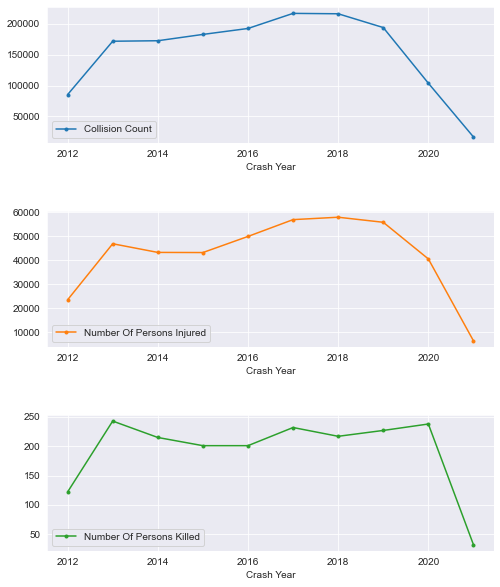

In [35]:
crash_year = collision_station_comb.groupby(['crash_year'],as_index=False).agg({'collision_id':'count',
                                                 'number_of_persons_injured':'sum',
                                                 'number_of_persons_killed':'sum'
                                                                   })
crash_year.columns = [col.replace('_',' ').title() for col in crash_year.columns]
crash_year.rename(columns={'Collision Id':'Collision Count'},inplace=True)

axes=crash_year.plot(x='Crash Year',subplots=True,rot=0,figsize=(8,10),style='.-',legend=True,sharex=False)
axes[0].legend(loc=3)
axes[1].legend(loc=3)
axes[2].legend(loc=3)
plt.subplots_adjust(hspace=0.5)
plt.show()

**Observation:**
- Accidents increased over the year until 2019.There's a significant drop in 2020 probably due to Covid 19 Outbreak

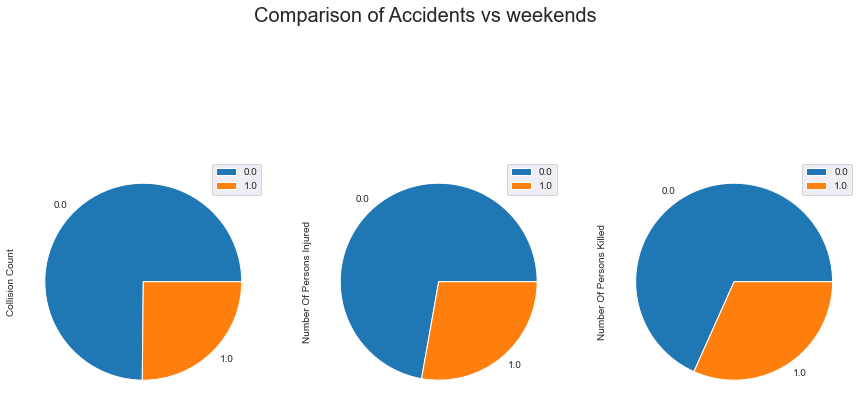

In [36]:
is_weekend = collision_station_comb.groupby(['is_weekend']).agg({'collision_id':'count',
                                                 'number_of_persons_injured':'sum',
                                                 'number_of_persons_killed':'sum'
                                                                   })

is_weekend.columns = [col.replace('_',' ').title() for col in is_weekend.columns]
is_weekend.rename(columns={'Collision Id':'Collision Count'},inplace=True)
is_weekend.plot.pie(subplots=True,figsize=(15,8))
plt.gcf().suptitle("Comparison of Accidents vs weekends",fontsize=20)
plt.show()

**Observation:**
- Mostly accidents occur in weekdays probably because these are working days

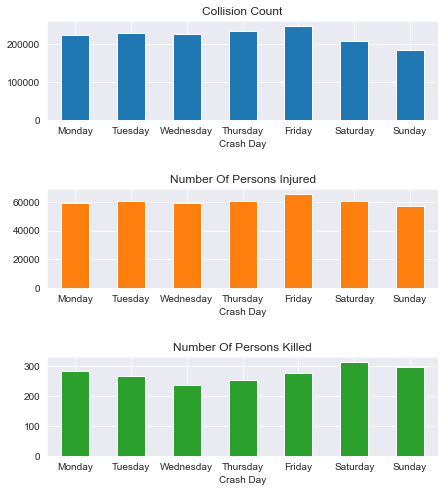

In [37]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

crash_day=collision_station_comb.groupby(['crash_day']).agg({'collision_id':'count',
                                                 'number_of_persons_injured':'sum',
                                                 'number_of_persons_killed':'sum'
                                                                   }).reindex(cats). \
                                                                    reset_index()

crash_day.columns = [col.replace('_',' ').title() for col in crash_day.columns]
crash_day.rename(columns={'Collision Id':'Collision Count'},inplace=True)
crash_day.plot.bar(x='Crash Day',subplots=True,rot=0,figsize=(7,8),legend=False,sharex=False)
plt.subplots_adjust(hspace=0.7)
plt.show()

**Observation:**
- More Accidents occur on Fridays, perhaps because it's the start of weekend.People go to their homes(near by counties/states), get out for partying while the daily traffic congestion is still there

## Predicting in which borough can an accident occur

### Trying Multiple Algorithms on sample for selecting the best performing the algorithm

In [38]:
data_2020 = collision_station_comb.loc[collision_station_comb.crash_date<pd.datetime(2020,1,1)]

data_2020_s = data_2020[['borough','number_of_persons_injured','number_of_persons_killed',
                        'number_of_pedestrians_injured','number_of_pedestrians_killed',
                        'number_of_cyclist_injured','number_of_cyclist_killed',
                        'number_of_motorist_injured','collision_id','number_of_motorist_killed',
                      'crash_month','crash_year','crash_week','crash_day_of_week',
                      'is_weekend','accident_reason']]

sample_df=data_2020_s.sample(frac=0.35, random_state=123)

X=sample_df[['number_of_persons_injured','number_of_persons_killed',
                        'number_of_pedestrians_injured','number_of_pedestrians_killed',
                        'number_of_cyclist_injured','number_of_cyclist_killed',
                        'number_of_motorist_injured','collision_id','number_of_motorist_killed',
                      'crash_month','crash_year','crash_week','crash_day_of_week',
                      'is_weekend']]#,'accident_reason'
y=sample_df[['borough']]

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0,stratify=y)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 376257 rows
Test Set: 125419 rows


In [39]:
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    MLPClassifier()]

clf_names = ['KNN','Decision Tree','RandomForest','AdaBoost','Naive Bayes','MLP']

accuracies = []
for name, clf in zip(clf_names, classifiers):
    print(name,':\n')
    ovr = OneVsRestClassifier(clf)
    ovr.fit(X_train, y_train)
    # make predictions
    y_hat = ovr.predict(X_test)
    accuracy = accuracy_score(y_test,y_hat)
    
    print(name,'Accuracy: ',np.round(accuracy,2))
    accuracies.append(np.round(accuracy*100.0,2))
    print(classification_report(y_test,y_hat))
    

KNN :

KNN Accuracy:  0.72
               precision    recall  f1-score   support

        BRONX       0.73      0.59      0.66     17825
     BROOKLYN       0.75      0.74      0.75     37083
    MANHATTAN       0.73      0.73      0.73     28293
       QUEENS       0.70      0.79      0.74     36029
STATEN ISLAND       0.61      0.56      0.59      6189

     accuracy                           0.72    125419
    macro avg       0.71      0.68      0.69    125419
 weighted avg       0.72      0.72      0.72    125419

Decision Tree :

Decision Tree Accuracy:  0.68
               precision    recall  f1-score   support

        BRONX       0.68      0.57      0.62     17825
     BROOKLYN       0.74      0.68      0.71     37083
    MANHATTAN       0.74      0.70      0.72     28293
       QUEENS       0.73      0.72      0.72     36029
STATEN ISLAND       0.29      0.64      0.40      6189

     accuracy                           0.68    125419
    macro avg       0.63      0.66      0

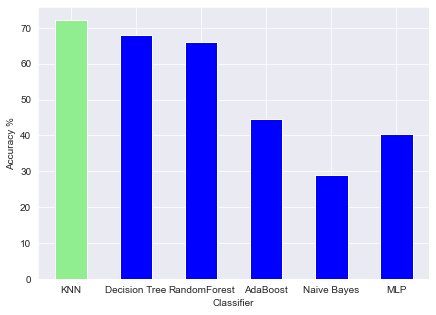

In [40]:
model_accs=pd.DataFrame(zip(clf_names,accuracies),columns=['Classifier','Accuracy'])
colors=['blue' if (acc < max(model_accs['Accuracy'])) else 'lightgreen' for acc in model_accs['Accuracy']]
axis=model_accs.plot.bar(x='Classifier',y='Accuracy',rot=0,figsize=(7,5),legend=False,sharex=False,color=colors)
plt.ylabel('Accuracy %')
plt.show()

**Observation:**
- KNN performed better than the rest therefore, we'll try tuning it further

### Hyper Parameter Tuning the best performing algorithm 

In [41]:
def tune_model(X,y):
    """Tuning the model to find best hyper parameters"""

    def acc_model(params):
        """Performing K Fold Cross Validation and Computing Accuracy Score for each fold"""
        
        clf = KNeighborsClassifier(**params,n_jobs=-1)
        #clf = RandomForestClassifier(**params, n_jobs=-1) #, class_weight='balanced'
        skf = StratifiedKFold(n_splits=5)
        f_scores_list = []
        for train_index, test_index in skf.split(data_x, data_y):
            clf.fit(data_x.iloc[train_index].astype('float'), data_y.iloc[train_index])
            result = clf.predict(data_x.iloc[test_index])
            f_scores_list.append(accuracy_score(data_y.iloc[test_index], result))
        return statistics.mean(f_scores_list)

    
    def objective(params):
        """objective function: minimising loss"""
        

        nonlocal best
        acc = acc_model(params)
        if acc > best:
            best = acc
        #print('new f1-score:', best, params)
        return {'loss': 1-acc, 'status': STATUS_OK}

    def parameterTuning():
        """Performing Bayesian Optimisation for Hyper Parameter Tuning"""
        
        param_space = {
            'n_neighbors': hp.choice('n_neighbors',[3,5,7,9]),
            'metric': hp.choice('metric',['chebyshev','minkowski','manhattan','euclidean']),
            'leaf_size': ho_scope.int(hp.quniform('leaf_size', low=20, high=40, q=1)),
            'weights' : hp.choice('weights',['uniform','distance'])
                        }
        
        trials = Trials()
        params = fmin(objective, param_space, algo=tpe.suggest, max_evals=40, trials=trials)
        params = space_eval(param_space, params)
        return params
    
    data_x=X
    data_y=y
    best=0
    tuned_params = parameterTuning()
    return tuned_params


In [42]:
# Starting Parameter tuning, This may take a while
params = tune_model(X_train,y_train)

100%|███████████████████████████████████████████████| 40/40 [15:12<00:00, 22.80s/trial, best loss: 0.25912340922897004]


In [43]:

# Selecting Data uptill 2019 for training & testing after tuning the selected model
data_2020_s = data_2020[['borough','number_of_persons_injured','number_of_persons_killed',
                        'number_of_pedestrians_injured','number_of_pedestrians_killed',
                        'number_of_cyclist_injured','number_of_cyclist_killed',
                        'number_of_motorist_injured','collision_id','number_of_motorist_killed',
                      'crash_month','crash_year','crash_week','crash_day_of_week',
                      'is_weekend','accident_reason']]

X=data_2020_s[['number_of_persons_injured','number_of_persons_killed',
                        'number_of_pedestrians_injured','number_of_pedestrians_killed',
                        'number_of_cyclist_injured','number_of_cyclist_killed',
                        'number_of_motorist_injured','collision_id','number_of_motorist_killed',
                      'crash_month','crash_year','crash_week','crash_day_of_week',
                      'is_weekend']]#,'accident_reason'
y=data_2020_s[['borough']]

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0,stratify=y)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

model_tuning = KNeighborsClassifier(**params)
# define the ovr_tuning strategy
ovr_tuning = OneVsRestClassifier(model_tuning)
# fit model_tuning
ovr_tuning.fit(X_train, y_train)
# make predictions
yhat = ovr_tuning.predict(X_test)

print(accuracy_score(y_test,yhat))
print(classification_report(y_test,yhat))

Training Set: 1003352 rows
Test Set: 430008 rows
0.7895364737400234
               precision    recall  f1-score   support

        BRONX       0.75      0.73      0.74     61176
     BROOKLYN       0.80      0.81      0.81    127536
    MANHATTAN       0.80      0.79      0.79     96989
       QUEENS       0.80      0.82      0.81    123118
STATEN ISLAND       0.75      0.69      0.72     21189

     accuracy                           0.79    430008
    macro avg       0.78      0.77      0.77    430008
 weighted avg       0.79      0.79      0.79    430008



**Observation:**
- Tuning the hyper parameters increased the accuracy significantly 